In [1]:
!pip3 install  transformers
!pip3 install seaborn
!pip3 install tqdm
!pip3 install ipywidgets


In [46]:
import transformers
import torch
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lib.data_processing
import importlib
from collections import defaultdict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

importlib.reload(lib.data_processing)

<module 'lib.data_processing' from '/home/biyas/projects/bias-scoring-algorithm/lib/data_processing.py'>

In [3]:
TRAIN_FP = 'bias_data/bias_data/WNC/biased.word.train'
TEST_FP = 'bias_data/bias_data/WNC/biased.word.test'

In [4]:
wnc_train = lib.data_processing.raw_data(TRAIN_FP, 3, 4)
wnc_train_df = wnc_train.add_miss_word_col(dtype='df')

wnc_test = lib.data_processing.raw_data(TEST_FP, 3, 4)
wnc_test_df = wnc_test.add_miss_word_col(dtype='df')

In [5]:
wnc_test_df.head(5)

,0,1,2,3,4,5,6,7
0,235640083,the 51 day stand ##off and ensuing murder of 7...,the 51 day stand ##off and ensuing deaths of 7...,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,DET NUM NOUN NOUN NOUN CCONJ VERB NOUN ADP NUM...,det nummod compound nsubj nsubj cc amod conj p...,"[murder, deaths]"
1,37561168,"mark o ##ate ##n ( born 8 march 1964 , watford...","mark o ##ate ##n ( born 8 march 1964 , watford...","mark oaten (born 8 march 1964, watford) is a d...","mark oaten (born 8 march 1964, watford) is a l...",NOUN ADJ ADJ ADJ PUNCT VERB NUM NOUN NUM PUNCT...,nsubj amod amod amod punct parataxis nummod np...,[disgraced]
2,101665256,another infamous period of colon ##isation in ...,another period of colon ##isation in ancient t...,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,DET ADJ NOUN ADP NOUN NOUN ADP ADJ NOUN VERB A...,det amod nsubj prep pobj pobj prep amod pobj R...,[infamous]
3,480248865,photo sequence of astonishing 2005 chicago ##l...,photo sequence of 2005 chicago ##land crash wi...,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,NOUN NOUN ADP VERB NUM NOUN NOUN NOUN ADP ADJ ...,compound ROOT prep amod nummod compound compou...,[astonishing]
4,317239242,jesus of nazareth is probably mentioned in two...,jesus of nazareth is possibly mentioned in two...,jesus of nazareth is probably mentioned in two...,jesus of nazareth is possibly mentioned in two...,PROPN ADP ADJ VERB ADV VERB ADP NUM NOUN ADP D...,nsubjpass prep pobj auxpass advmod ROOT prep n...,"[probably, possibly]"


In [6]:
sample = lib.data_processing.raw_data('bias_data/bias_data/real_world_samples/ibc_right', 2, 3)
sample.add_miss_word_col(dtype='df').head(5)

,0,1,2,3,4,5,6,7
0,b057ee3e-ef62-4126-a681-dd4a86b25a15,"when told of thompson ' s appointment , nixon ...","when told of thompson ' s appointment , nixon ...","when told of thompson 's appointment , nixon r...","when told of thompson 's appointment , nixon r...",ADV VERB ADP NOUN PUNCT VERB NOUN PUNCT NOUN V...,advmod advcl prep nmod punct compound pobj pun...,"[', s, `, `, ', ', `, `, 's, ``, '', ``]"
1,9c8e1855-c9d0-45d1-b1c6-a8e8a5eb7f61,some parents might argue that placing their ch...,some parents might argue that placing their ch...,some parents might argue that placing their ch...,some parents might argue that placing their ch...,DET NOUN VERB VERB ADP VERB ADJ NOUN ADP NOUN ...,det nsubj aux ROOT mark csubj poss dobj prep c...,"[re, ##ap, ##ing, tax, ##ed, reaping, taxed]"
2,a0f170e2-0c0c-49ca-9b53-9d758bf295b8,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,beneath this bland good obama lies a more inte...,ADP DET ADJ ADJ NOUN VERB DET ADV ADJ NOUN PUN...,prep det amod amod pobj ROOT det advmod amod n...,"[better, -, the, ', s, self, -, pity, un, ##fu..."
3,5313376a-876f-4af7-9a33-52c964e48898,"worse yet , it s ##neer ##ingly de ##pre ##cat...","worse yet , it s ##neer ##ingly de ##pre ##cat...","worse yet , it sneeringly deprecates the genui...","worse yet , it sneeringly deprecates the genui...",ADV ADV PUNCT PRON ADV ADV ADV VERB VERB VERB ...,advmod advmod punct nsubj advmod advmod advmod...,"[s, ##neer, ##ingly, de, ##pre, ##cate, ##s, a..."
4,9beb9114-f3b9-4788-ae7e-c03634593860,and obama ' s pick to head the department of a...,and obama ' s pick to head the department of a...,and obama 's pick to head the department of ag...,and obama 's pick to head the department of ag...,CCONJ NOUN PUNCT VERB VERB PART VERB DET NOUN ...,cc nsubj punct nsubj nsubj aux xcomp det dobj ...,"[', s, vi, ##ls, ##ack, manipulation, ##s, 's,..."


In [7]:
train_df = wnc_train.make_training_array(wnc_train_df)
test_df = wnc_test.make_training_array(wnc_test_df)

train_df.head()

,string,label
0,one of the features of sasthamcotta temple is ...,0
1,metal gear solid 4: guns of the patriots (comm...,1
2,some composers of non-orchestral film scores i...,0
3,the republic of india is a large third-world c...,1
4,he next studied at the moscow conservatory wit...,1


[Text(0, 0, 'Unbiased'), Text(1, 0, 'Biased')]

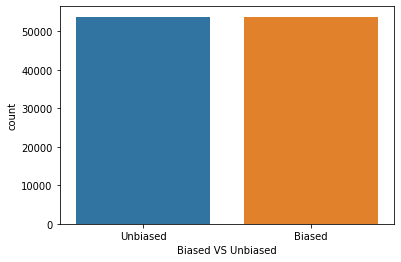

In [8]:
class_names = ["Unbiased", "Biased"]
ax = sns.countplot(train_df.label)
plt.xlabel('Biased VS Unbiased')
ax.set_xticklabels(class_names)

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
# some testing
sample_txt = 'Finals Week!!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Finals Week!!
   Tokens: ['Finals', 'Week', '!', '!']
Token IDs: [9801, 6237, 106, 106]


In [20]:
# choosing sequence length

token_lens = []

for row in train_df.string:
  tokens = tokenizer.encode(row, max_length=512, truncation=True)
  token_lens.append(len(tokens))

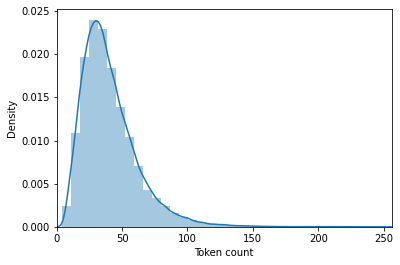

In [21]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [22]:
## most strings are less than 150 tokens

MAX_LEN = 150

In [26]:
class WNCDataset(Dataset):
    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'sentence': sentence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }
    

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = WNCDataset(
    sentences=df.string.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=10
  )

In [31]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys() 

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [37]:
class BiasClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BiasClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)



In [38]:
model = BiasClassifier(len(class_names))


In [ ]:
## TRAINING

In [42]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

In [43]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer,
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    targets = d["targets"]

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def eval_model(model, data_loader, loss_fn, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      targets = d["targets"]

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer,
    scheduler, 
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device, 
    len(test_df)
  )

  print(f'Val   loss {test_loss} accuracy {test_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)


Epoch 1/10
----------


NameError: name 'df_train' is not defined

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);